In [1]:
import pandas as pd
import os
from enum import Enum
import numpy as np
import scipy
from numpy import sqrt, sin, cos, tan, pi
from scipy.integrate import odeint
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import ticker, cm
from matplotlib import ticker
from scipy.optimize import minimize
from scipy.optimize import Bounds
%matplotlib
 
'''Water'''
density = 997
dynamicViscosity = 0.0008891
kinematicViscosity = 8.917*10**-7
TotalMassFlowRate = 1 # 0.5, 2

'''Can be Set'''
voluteThickness = 0.005
discThickness = 0.0008
discSpacing = 0.0002
wallSpace = 0.001
wallDisplacement = 0.003

'''Base Case'''
nDisc = 5
rotorOuter = 0.073
rotorInner = 0.3*rotorOuter
revPerMinute = [2000]

'''formatting for plots'''
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
class flowParameters():
    def __init__(self, innerRadius, outerRadius, discSpacing, discThickness, numberSpacing,
                  voluteThickness, voluteWallSpace, upperClearance, wallDisplacement,
                  totMassFlowRate, density, RPM, k_Width_h0 = 0.798, profileN = 2):
        self.innerRadius = innerRadius
        self.outerRadius = outerRadius
        self.discSpacing = discSpacing
        self.discThickness = discThickness
        self.voluteWallSpace = voluteWallSpace
        self.upperClearance = upperClearance
        self.numberSpacing = numberSpacing
        self.massFlowRate = totMassFlowRate
        self.density = density
        self.Fpo = (profileN + 1)/3
        
        self.voluteSpace = numberSpacing*discSpacing + (numberSpacing-1)*discThickness
        self.totalVoluteSpace = 2*discThickness + self.voluteSpace + 2*self.voluteWallSpace + 2*wallDisplacement
        self.h0 = k_Width_h0*self.totalVoluteSpace
        self.r0 = self.outerRadius + self.upperClearance + voluteThickness + self.totalVoluteSpace/2 + \
            cos(np.arcsin((self.totalVoluteSpace - self.h0)/self.h0))*self.h0
        
        #formula
        self.inletAngle = flowParameters.derivedAngle(self.voluteSpace, self.h0, self.r0)
        self.vRadial, self.vTheta = flowParameters.velocityInlet(self)
        
        self.omega = RPM*2*pi/60
        self.DH = 2*self.discSpacing
        self.massFlowRatePD = self.massFlowRate/self.numberSpacing
        self.volumeFlowRatePD = self.massFlowRatePD/density
        
        self.tipVelocity = self.omega*self.outerRadius
        self.relativeTipTangential = (self.vTheta - self.tipVelocity)/self.tipVelocity
        self.innerOuterRatio = self.innerRadius/self.outerRadius
        self.reynoldM = self.massFlowRatePD/(pi*self.outerRadius*dynamicViscosity)
        self.reynoldMS = self.reynoldM * self.DH / self.outerRadius
        
    def derivedAngle(vSpace, vIRadius, vRadius):
        degree = np.arctan(2*vSpace*vRadius/(vIRadius**2))
        return 0.5*pi - degree
    
    def velocityInlet(self):
        effectiveArea = 2*pi*(self.outerRadius+self.upperClearance)*(self.numberSpacing*self.discSpacing)
        vRadial = self.massFlowRate/(effectiveArea*self.density)
        vTheta = vRadial/tan(self.inletAngle)
        vRadialDisc = vRadial*self.outerRadius/(self.outerRadius-self.upperClearance)
        return -vRadialDisc, vTheta

def bothODE(y,x,instance):
    y0,y1 = y

    nTerm = 3*instance.Fpo - 1 # article definition
    Vr0 = instance.vRadial/instance.tipVelocity

    firstSolution = -(2*nTerm + 1)/(nTerm + 1) + (8*(2*nTerm + 1)*x/instance.reynoldMS - 1/x)*y0
    secondSolution = (4*(nTerm + 1)/(2*nTerm + 1))*(1/x**3)*(Vr0**2 + (y0*x)**2) +\
                    4*y0 + 2*x + 32*(nTerm + 1)*(Vr0**2)/(x*instance.reynoldMS)
    return [firstSolution, secondSolution]

def rotorEff(firstAnswer, rs, instance): # ignore for now
    return (1 - (firstAnswer[-1] + instance.innerOuterRatio)*instance.innerOuterRatio\
            /(firstAnswer[0] + 1))

def power(firstAnswer, rs, instance):
    firstAnswerFlip = np.squeeze(np.flip(firstAnswer))
    rsFlip = np.flip(rs)

    constantTerm = (instance.outerRadius**3)*(2*pi/instance.discSpacing)*\
            (6*dynamicViscosity*instance.tipVelocity)*instance.Fpo
    integrateTerm = firstAnswerFlip*np.power(rsFlip,2)
    return 2*instance.omega*instance.numberSpacing*\
        constantTerm*scipy.integrate.simps(integrateTerm, x = rsFlip)

def solutionGenerator(rotorInner, rotorOuter, discSpacing, discThickness, numberSpacing,
                     voluteThickness, wallSpace, upperClearance, wallDisplacement,
                     TotalMassFlowRate, density, RPM, profileN = 2, rsPoint = 100):
    KJ = flowParameters(rotorInner, rotorOuter, discSpacing, discThickness, numberSpacing,
                voluteThickness, wallSpace, upperClearance, wallDisplacement,
                TotalMassFlowRate, density, RPM, profileN = profileN)
    firstODEinitial,secondODEinitial = KJ.relativeTipTangential, 0
    rs = np.linspace(1, KJ.innerOuterRatio, rsPoint)
    sol = odeint(bothODE, [firstODEinitial,secondODEinitial], rs, args=(KJ,))
    return KJ, sol, rs

'''Extras'''
def profilePlot(axPlot, instance, numberZPoints): # profile plot in between discs
    zPoints = np.linspace(-instance.discSpacing/2, instance.discSpacing/2, numberZPoints)
    nVal = 3*instance.Fpo - 1
    xVal = ((nVal+1)/nVal)*(np.full((numberZPoints,),1) - np.power(2*zPoints/instance.discSpacing,nVal))
    axPlot.set_ylabel("Z position relative to DSC", color="white")
    axPlot.set_xlabel("Profile Magnitude (Dimensionless)", color="white")
    axPlot.plot(xVal, zPoints)

'''finding the best rpm for highest power output (not working)'''
def costJ(x, instance):
    optRPM = x[0]
    instance.omega = optRPM*2*pi/60
    
    firstODEinitial, secondODEinitial = instance.relativeTipTangential, 0
    rs = np.linspace(1, instance.innerOuterRatio, 100)
    sol = odeint(bothODE, [firstODEinitial,secondODEinitial], rs, args=(instance,))
    return (1000-power(sol[:,0], rs, instance))**2

    
def shaftLosses(instance): # negligible
    wR2 = instance.omega*instance.outerRadius**2
    reDisc = wR2/kinematicViscosity
    tipGap = (instance.totalVoluteSpace)/2 + instance.upperClearance
    endGap = instance.voluteWallSpace
    condition = 470.5*instance.outerRadius/endGap
    if reDisc < condition:
        exponent = 1 # laminar gap
    else:
        exponent = 0.25 # turbulent gap
    cFactorGap = ((instance.outerRadius/(reDisc*endGap))**exponent)*\
        (2*pi if exponent == 1 else 0.00622)*(1/(instance.numberSpacing + 1))
    cFactorTip = (instance.discThickness/tipGap)*(4*pi*kinematicViscosity/wR2)
    torqueLoss = (0.5*instance.discSpacing/instance.outerRadius)*(cFactorGap + cFactorTip)
    return torqueLoss*instance.omega*(instance.numberSpacing+1)

In [2]:
'''Base Case Simulation'''

KJ, sol, rs = solutionGenerator(rotorInner, rotorOuter, discSpacing, discThickness, nDisc-1,
                 voluteThickness, wallSpace, 0, wallDisplacement,
                 TotalMassFlowRate, density, revPerMinute[0])

print(
        f"Disc Number:\t{KJ.numberSpacing+1}"+"\n"+
        f"Total Volute Space:\t\t{KJ.totalVoluteSpace} m"+"\n"+
        f"Total Disc Space:\t\t{KJ.voluteSpace} m"+"\n"+
        f"r0 is:\t\t{KJ.r0} m"+"\n"+
        f"Outer radius:\t{KJ.outerRadius} m"+"\n"+
        f"h is:\t\t{KJ.h0} m"+"\n"+
        f"Angle:\t\t{KJ.inletAngle*180/pi} dg from tangent line"+"\n"+
        f"R ratio:\t{KJ.innerOuterRatio}"+"\n"+
        f"Vr:\t\t{KJ.vRadial} \t\tVt:\t\t{KJ.vTheta}"+"\n"+
        f"Reynold:\t{KJ.reynoldM}"+"\n"+
        f"Reynold*:\t{KJ.reynoldMS}"+"\n"+
        f"W0:\t\t{KJ.relativeTipTangential}"+"\n"+
        f"Power:\t\t{power(sol[:,0], rs, KJ)} W"+"\n"+
        f"Friction Loss: \t{shaftLosses(KJ)} W"
    )

Disc Number:	5
Total Volute Space:		0.0128 m
Total Disc Space:		0.0032 m
r0 is:		0.09428173264159682 m
Outer radius:	0.073 m
h is:		0.0102144 m
Angle:		9.809972073699244 dg from tangent line
R ratio:	0.3
Vr:		-2.7334562435919976 		Vt:		15.808619019367883
Reynold:	1226.073951124158
Reynold*:	6.718213430817304
W0:		0.03398076454340421
Power:		148.32308914550126 W
Friction Loss: 	0.00015775030961111687 W


<IPython.core.display.Javascript object>


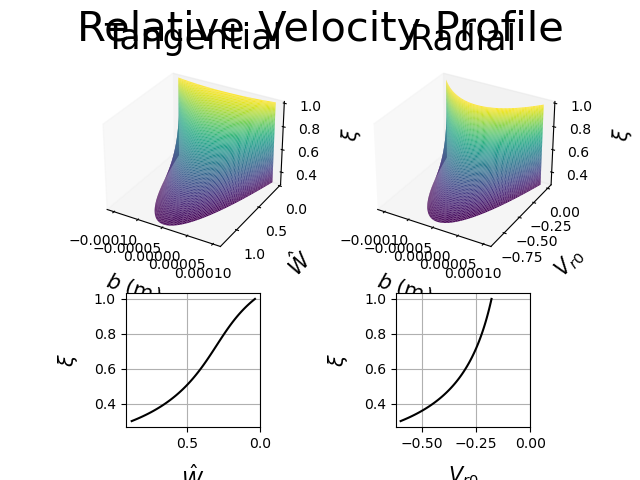

Text(0.5, 0.98, 'Relative Velocity Profile')

In [3]:
'''Relative Tangential & Radial Profile'''
def f(x, y, instance):
    nVal = 3*instance.Fpo - 1
    phiZ = ((nVal+1)/nVal)*(1-np.power((2*xPoints/instance.discSpacing),nVal))
    phiZ = np.reshape(phiZ, (1, len(phiZ)))
    return phiZ.transpose()*y
tangentialAve = sol[:,0]
xPoints = np.linspace(-KJ.discSpacing/2, KJ.discSpacing/2, 100)
yPoints = rs
Z1 = f(xPoints, tangentialAve, KJ).transpose()
xPoints, yPoints = np.meshgrid(xPoints, yPoints)

X1 = xPoints
Y1 = yPoints

radialAve = (1/rs)*KJ.vRadial/KJ.tipVelocity
xPoints = np.linspace(-KJ.discSpacing/2, KJ.discSpacing/2, 100)
Z2 = f(xPoints, radialAve, KJ).transpose()
X2 = xPoints
Y2 = yPoints

'''plots'''
fig = plt.figure()

spec = mpl.gridspec.GridSpec(ncols=2, nrows=2,
                         height_ratios=[1.5, 1])


ax0 = fig.add_subplot(spec[0], projection='3d')
ax1 = fig.add_subplot(spec[1], projection='3d')
ax10 = fig.add_subplot(spec[2])
ax11 = fig.add_subplot(spec[3])


ax0.plot_surface(X1, Z1, Y1, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax0.set_xlabel("$\it{b}$ (m)", labelpad=10, fontsize = 15)
ax0.xaxis.set_ticks(np.linspace(-KJ.discSpacing/2, KJ.discSpacing/2, 5))
ax0.set_ylabel("$\^{W}$", labelpad=10, fontsize = 15)
ax0.set_zlabel(r"$\xi$", labelpad=10, fontsize = 15)
ax0.set_title('Tangential', fontsize = 25)
ax0.set_ylim(np.amax(Z1),0)
ax0.grid(False)

ax1.plot_surface(X2, Z2, Y2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax1.set_xlabel("$\it{b}$ (m)", labelpad=10, fontsize = 15)
ax1.xaxis.set_ticks(np.linspace(-KJ.discSpacing/2, KJ.discSpacing/2, 5))
ax1.set_ylabel(r"$V_{r0}$", labelpad=10, fontsize = 15)
ax1.set_zlabel(r"$\xi$", labelpad=10, fontsize = 15)
ax1.set_title('Radial', fontsize = 25)
ax1.grid(False)

ax10.plot(tangentialAve, rs, color="black")
ax10.invert_xaxis()
ax10.set_ylabel(r"$\xi$", labelpad=10, fontsize = 15)
ax10.set_xlabel("$\^{W}$", labelpad=10, fontsize = 15)
ax10.set_xlim(right=0)
ax10.set_box_aspect(1)
ax10.grid()

ax11.plot(radialAve, rs, color="black")
ax11.set_ylabel(r"$\xi$", labelpad=10, fontsize = 15)
ax11.set_xlabel(r"$V_{r0}$", labelpad=10, fontsize = 15)
ax11.set_box_aspect(1)
ax11.set_xlim(right=0)
ax11.grid()
# ax.patch.set_facecolor('grey')
fig.suptitle('Relative Velocity Profile', fontsize = 30)

In [158]:
"""Angle relative to spinning disc"""
radialPr = abs((1/rs)*KJ.vRadial/KJ.tipVelocity)
tangentialPr = sol[:,0]
angleProfile = np.arctan(radialPr/ tangentialPr)*180/pi
fig,ax = plt.subplots(1, 2, gridspec_kw={
                           'width_ratios': [1, 1.25]})
ax[0].plot(rs, angleProfile, '--', color='black')

ax[0].set_xlabel(r"$\xi$", fontsize=15)
ax[0].set_xlim(left=rs[-1], right=rs[0])
ax[0].set_ylabel('Angle (\N{DEGREE SIGN})', fontsize=15)

radialPr = abs((1/rs)*KJ.vRadial/KJ.tipVelocity)
tangentialPr = sol[:,0]
angleProfile = np.arctan(radialPr/ tangentialPr)*180/pi

'''Unit Vector Case'''
startX = 2.5
for i in range(len(angleProfile)):
    if i%10 == 0:
        currentAngle = angleProfile[i]
        vectorToX, vectorToY = sin(currentAngle*pi/180)/5, -cos(currentAngle*pi/180)/5
        ax[1].arrow(startX, rs[i], -vectorToX, vectorToY, color="crimson", shape="full", head_width=0.025)
        
ax[1].plot([startX, startX],[rs[-1], rs[0]], "--", color="black")

ax[1].plot([0, 5],[rs[-1], rs[-1]], ":", color="black")
ax[1].plot([0, 5],[rs[0], rs[0]], ":", color="black")
ax[1].set_ylabel(r"$\xi$", fontsize=15)
ax[1].axes.xaxis.set_visible(False)

theta = np.linspace(0, np.pi, 100)

r1 = rs[-1]
x1 = r1*np.cos(theta) + startX
y1 = r1*np.sin(theta)
ax[1].plot(x1, y1, color="black")

r2 = rs[0]
x2 = r2*np.cos(theta) + startX
y2 = r2*np.sin(theta)
ax[1].plot(x2, y2, color="black")

inner = rs[-1]
xs = np.linspace(-rs[0]+startX,rs[0]+startX, 201)
ys = np.linspace(-rs[0],rs[0], 201)
xv,yv = np.meshgrid(xs,ys)
r = (xv-startX)**2 + yv**2
ax[1].contourf(xv, yv, r, levels=[inner**2, rs[0]**2], colors="grey")

ax[1].set_xlim(left=1.5, right=3.5)
ax[1].set_ylim(bottom=0, top=rs[0]+0.1)
ax[1].set_aspect(1)

fig.suptitle("Velocity Angle", fontsize = 30)

Text(0.5, 0.98, 'Velocity Angle')

In [210]:
maxRotorOuter = 0.164
kFactorRange = np.linspace(1,5,50)

"""
# Using updated base model #

maxRotorOuter = 0.073
kFactorRange = np.linspace(1/2.25,2.25,50)
"""

nDiscRange = np.arange(1,17,1)
discSpacingRange = np.arange(0.0002,0.001,0.0001)
rpmRange = np.linspace(50,5000,100)

bSpacing = discSpacingRange[0] # choosing smallest possible disc spacing
hiOutput = 0

powerStorageStore = []
for j in range(len(nDiscRange)):
    powerStorage = np.zeros([len(rpmRange),len(kFactorRange)])
    X,Y = np.meshgrid(rpmRange,kFactorRange)

    discNumberSpacing = nDiscRange[j]

    for k in range(len(rpmRange)):
        effectiveRPM = rpmRange[k]
        for l in range(len(kFactorRange)):
            maxRotorOuterCase = maxRotorOuter/kFactorRange[l]
            KJ, sol, rs = solutionGenerator(0.3*maxRotorOuterCase, maxRotorOuterCase, bSpacing, \
                            discThickness, discNumberSpacing, voluteThickness, wallSpace, 0, wallDisplacement,
                             TotalMassFlowRate, density, effectiveRPM)
            
            powerStorage[k,l] = power(sol[:,0], rs, KJ)
            if powerStorage[k,l]>hiOutput:
                hiOutput = powerStorage[k,l]
    powerStorageStore.append(powerStorage)
    

X,Y = np.meshgrid(rpmRange,kFactorRange)
powerStorageStore = np.array(powerStorageStore)

'''Plots'''

plt.rcParams["figure.figsize"]=12, 12
fig, axs = plt.subplots(4,4)
# levels = np.arange(0,int(hiOutput)+1,1)
levels = np.arange(0,101,5)
countX, countY = 0,0
for i in range(len(powerStorageStore)):
    if(countY==4):
        countX+=1
        countY=0
    cs = axs[countX,countY].contourf(X,Y,powerStorageStore[i].transpose(),levels=levels,\
                                     extend='both',cmap="coolwarm")
    axs[countX,countY].set_title(f'n = {i+2}',color='white',fontsize=15)
    axs[countX,countY].tick_params(axis='x', colors='white',labelsize=12)
    axs[countX,countY].tick_params(axis='y', colors='white',labelsize=12)
    if countX==0 and countY==3:
        axs[countX,countY].grid(color='white')
    countY+=1

plt.subplots_adjust(wspace = .2)
fig.add_subplot(111, frame_on=False)
fig.suptitle("Power Output Contour", color="white", fontsize=30, x=0.45)

plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("RPM", fontsize=25, color='white', position=(0.4, 0.5), labelpad=15)
plt.ylabel("Scale Factor", fontsize=25, color='white', position=(0.4, 0.5), labelpad=15)

fig.tight_layout()
cbar = plt.colorbar(cs,ax=axs)
cbar.ax.set_ylabel('Power (W)', fontsize=25)
cbar.ax.yaxis.label.set_color('white')
cbar.ax.tick_params(axis='y', colors='white')

ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=15)

fig.patch.set_facecolor('#373E4B')

In [209]:
maxRotorOuter = 0.073
nDiscRange = np.arange(1,17,1)
discSpacingRange = np.arange(0.0002,0.001,0.0001)
kFactorRange = np.linspace(1/2.25,2.25,50)
rpmRange = np.linspace(50,5000,100)

bSpacing = discSpacingRange[0] # choosing smallest possible disc spacing
hiOutput = 0

powerStorageStore = []
for j in range(len(nDiscRange)):
    powerStorage = np.zeros([len(rpmRange),len(kFactorRange)])
    X,Y = np.meshgrid(rpmRange,kFactorRange)

    discNumberSpacing = nDiscRange[j]

    for k in range(len(rpmRange)):
        effectiveRPM = rpmRange[k]
        for l in range(len(kFactorRange)):
            maxRotorOuterCase = maxRotorOuter/kFactorRange[l]
            KJ, sol, rs = solutionGenerator(0.3*maxRotorOuterCase, maxRotorOuterCase, bSpacing, \
                            discThickness, discNumberSpacing, voluteThickness, wallSpace, 0, wallDisplacement,
                             TotalMassFlowRate, density, effectiveRPM)
            
            powerStorage[k,l] = power(sol[:,0], rs, KJ)
            if powerStorage[k,l]>hiOutput:
                hiOutput = powerStorage[k,l]
    powerStorageStore.append(powerStorage)
    
    plt.rcParams["figure.figsize"]=30,24

X,Y = np.meshgrid(rpmRange,kFactorRange)
powerStorageStore = np.array(powerStorageStore)

'''Plots'''

plt.rcParams["figure.figsize"]=12, 12
fig, axs = plt.subplots(4,4)
# levels = np.arange(0,int(hiOutput)+1,1)
levels = np.arange(0,101,5)
countX, countY = 0,0
for i in range(len(powerStorageStore)):
    if(countY==4):
        countX+=1
        countY=0
    cs = axs[countX,countY].contourf(X,Y,powerStorageStore[i].transpose(),levels=levels,\
                                     extend='both',cmap="coolwarm")
    axs[countX,countY].set_title(f'n = {i+2}',color='white',fontsize=15)
    axs[countX,countY].tick_params(axis='x', colors='white',labelsize=12)
    axs[countX,countY].tick_params(axis='y', colors='white',labelsize=12)
    if countX==0 and countY==3:
        axs[countX,countY].grid(color='white')
    
    countY+=1

plt.subplots_adjust(wspace = .2)
fig.add_subplot(111, frame_on=False)
fig.suptitle("Power Output Contour", color="white", fontsize=30, x=0.45)

plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("RPM", fontsize=25, color='white', position=(0.4, 0.5), labelpad=15)
plt.ylabel("Scale Factor", fontsize=25, color='white', position=(0.4, 0.5), labelpad=15)

fig.tight_layout()
cbar = plt.colorbar(cs,ax=axs)
cbar.ax.set_ylabel('Power (W)', fontsize=25)
cbar.ax.yaxis.label.set_color('white')
cbar.ax.tick_params(axis='y', colors='white')

ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=15)

fig.patch.set_facecolor('#373E4B')

In [213]:
'''Mass Flow Rate Comparison on different application settings'''
inletArea = 0.0004

def damVelocity(height):
    g = 9.81
    c0 = sqrt(g*height)
    return 2*c0

def stream(hydraulicRadius, Slope, formulaType):
    u_m = 1
    u_c = 0.552
    manningN = 0.035
    chezyC = (u_m*hydraulicRadius**(1/6))/(u_c*manningN)
    if formulaType == "manning":
        velocity = (u_m/manningN)*(hydraulicRadius**(2/3))*(Slope**0.5)
    elif formulaType == "chezy":
        velocity = u_c*chezyC*(hydraulicRadius**0.5)*(Slope**0.5)
    else:
        raise Exception("Unidentified formula type")
    return velocity

smallDam = density*inletArea*damVelocity(10)
tapWater = 1
smallRiver = 0.7

hRadius = 0.5035345/pi*0.17526
river10 = stream(hRadius, tan(10*pi/180), "manning")
river20 = stream(hRadius, tan(20*pi/180), "manning")
river30 = stream(hRadius, tan(30*pi/180), "manning")
waterFall = 8.9
referenceStream = {
    "river": smallRiver,
    "river 10\N{DEGREE SIGN}": river10,
    "river 20\N{DEGREE SIGN}": river20,
    "river 30\N{DEGREE SIGN}": river30,
    "tap water": tapWater,
    "small dam": smallDam,
    "waterfall": waterFall
}
massFlowRateRange = np.arange(0.5, 3, 0.1)
rpmRange = np.linspace(50,5000,100)

'''Base Case'''
voluteThickness = 0.005
discThickness = 0.0008
discSpacing = 0.0002
wallSpace = 0.001
wallDisplacement = 0.003

nDiscBase = 5
rotorOuter = 0.073
rotorInner = 0.3*rotorOuter

hiOutput = 0

powerStorageStore = []

for i in range(len(rpmRange)):
    powerStorageStore.append([])
    effectiveRPM = rpmRange[i]
    for j in range(len(massFlowRateRange)):
        currentMFR = massFlowRateRange[j]
        KJ, sol, rs = solutionGenerator(rotorInner, rotorOuter, discSpacing, \
                        discThickness, nDiscBase - 1, voluteThickness, wallSpace, 0, wallDisplacement,
                         currentMFR, density, effectiveRPM)

        currentOutput = power(sol[:,0], rs, KJ)
        powerStorageStore[i].append(currentOutput)
        if currentOutput > hiOutput:
            hiOutput = currentOutput
X,Y = np.meshgrid(rpmRange,massFlowRateRange)
powerStorageStore = np.array(powerStorageStore)

'''Plots'''
contourLevel = int(round((massFlowRateRange[-1]-massFlowRateRange[0])/1.5, 0)*50)
fig, axs = plt.subplots(figsize=(15,15))
levels = np.arange(0, int(hiOutput)+1, contourLevel)
# levels = np.arange(0,101,5)
cs = axs.contourf(X,Y,powerStorageStore.transpose(),levels=levels,\
                                     extend='both',cmap="coolwarm")
for i in list(referenceStream.keys()):
    if referenceStream[i] >= massFlowRateRange[-1]:
        pass
    else:
        axs.plot([rpmRange[0], rpmRange[-1]], [referenceStream[i],referenceStream[i]],'--', color='black')
        axs.text(rpmRange[5], referenceStream[i] + 0.025, f'{i}', color="white", fontsize=15)
axs.set_title("Performance Matrix",color='white',fontsize=30, pad=20)

axs.set_xlabel('RPM', color='white', fontsize=25)
axs.tick_params(axis='x', colors='white')
axs.set_ylabel('Mass Flow Rate (kg/s)', color='white', fontsize=25)
axs.tick_params(axis='y', colors='white')
axs.set_ylim(top=massFlowRateRange[-1], bottom=massFlowRateRange[0])
axs.set_xlim(left=rpmRange[0], right=rpmRange[-1])

cbar = plt.colorbar(cs,ax=axs)
cbar.ax.set_ylabel('Power (W)', fontsize=25)
cbar.ax.yaxis.label.set_color('white')
cbar.ax.tick_params(axis='y', colors='white')

ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=25)
fig.patch.set_facecolor('#373E4B')

In [230]:
'''upScaling & PowerRatio'''
'''every aspect set as constant except radius and disc spacing'''
defaultRPM = np.array(revPerMinute)
nomKJ, nomSol, nomRs = solutionGenerator(rotorInner, rotorOuter, discSpacing, \
                            discThickness, nDisc - 1, voluteThickness, wallSpace, 0, wallDisplacement,
                             TotalMassFlowRate, density, defaultRPM[0])
nominalPower = power(nomSol[:,0], nomRs, nomKJ)

kScale = np.arange(0.0,1.0,0.2)
rScale = np.arange(0.5, 2, 0.01)

scalingNominalPowerStorage = []
scalingMechanicalEff = []
for i in range(len(kScale)):
    scalingNominalPowerStorageTemp = []
    scalingMechanicalEffTemp = []
    for j in range(len(rScale)):
        currentRotorOuter = rotorOuter*rScale[j]
        currentRotorInner = rotorInner
        currentDiscSpacing = (rScale[j]**kScale[i])*discSpacing
        
        KJ, sol, rs = solutionGenerator(currentRotorInner, currentRotorOuter, currentDiscSpacing, \
                            discThickness, nDisc - 1, voluteThickness, wallSpace, 0, wallDisplacement,
                             TotalMassFlowRate, density, defaultRPM[0])
        
        currentRotorEff = rotorEff(sol[:,0], rs, KJ)
        scalingMechanicalEffTemp.append(currentRotorEff)
        
        currentPowerOut = power(sol[:,0], rs, KJ)
        powerRatio = currentPowerOut/nominalPower
        scalingNominalPowerStorageTemp.append(powerRatio)
    scalingMechanicalEff.append(scalingMechanicalEffTemp)
    scalingNominalPowerStorage.append(scalingNominalPowerStorageTemp)

scalingMechanicalEff = 100*np.array(scalingMechanicalEff) # convert to percentage format
scalingNominalPowerStorage = np.array(scalingNominalPowerStorage)

fig,ax = plt.subplots(figsize=(15,15))
for i in range(len(scalingNominalPowerStorage)):
    ax.plot(rScale, scalingNominalPowerStorage[i], label=f'k = {round(kScale[i],2)}')
ax.set_xlabel('$r_0$ Scale', color='white', fontsize=20)
ax.set_ylabel('Output Ratio', color='white', fontsize=20)
ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)
plt.legend(fontsize=15)

fig1,ax1 = plt.subplots(figsize=(15,15))
for i in range(len(scalingMechanicalEff)):
    ax1.plot(rScale, scalingMechanicalEff[i], label=f'k = {round(kScale[i],2)}')
ax1.set_xlabel('$r_0$ Scale', color='white', fontsize=25)
ax1.set_ylabel('Mechanical Efficiency (%)', color='white', fontsize=25)
ax1.set_ylim(top=80, bottom=30)
ax1.tick_params(axis='x', colors='white', labelsize=15)
ax1.tick_params(axis='y', colors='white', labelsize=15)
plt.legend(fontsize=15)

ax.grid()
ax1.grid()
fig.patch.set_facecolor('#373E4B')
fig1.patch.set_facecolor('#373E4B')

In [238]:
'''upScaling & powerDensity'''
'''every aspect set as constant except radius and disc spacing'''
kScale = np.array([0.0,0.15,0.33,0.5,1.0])
rScale = np.arange(0.31, 1.5, 0.01)

scalingPowerDensityStorage = []
scalingPowerStorage = []
scalingVolumeStorage = []
defaultRPM = np.array(revPerMinute)

for i in range(len(kScale)):
    scalingPowerDensityStorageTemp = []
    scalingPowerStorageTemp = []
    scalingVolumeStorageTemp = []
    for j in range(len(rScale)):
        currentRotorOuter = rotorOuter*rScale[j]
        currentRotorInner = rotorInner # rotor inner set as constant
        currentDiscSpacing = (rScale[j]**kScale[i])*discSpacing
        
        KJ, sol, rs = solutionGenerator(currentRotorInner, currentRotorOuter, currentDiscSpacing, \
                            discThickness, nDisc - 1, voluteThickness, wallSpace, 0, wallDisplacement,
                             TotalMassFlowRate, density, defaultRPM[0])
        
        currentPowerOut = power(sol[:,0], rs, KJ)
        scalingPowerStorageTemp.append(currentPowerOut)
        currentVolume = (nDisc - 1)*(pi*currentRotorOuter**2)*currentDiscSpacing # 4 signifies the number spacing
        scalingVolumeStorageTemp.append(currentVolume)
        scalingPowerDensityStorageTemp.append(currentPowerOut/currentVolume)
    scalingVolumeStorage.append(scalingVolumeStorageTemp)
    scalingPowerStorage.append(scalingPowerStorageTemp)
    scalingPowerDensityStorage.append(scalingPowerDensityStorageTemp)

'''Reference'''
KJ, sol, rs = solutionGenerator(rotorInner, rotorOuter, discSpacing, \
                            discThickness, nDisc - 1, voluteThickness, wallSpace, 0, wallDisplacement,
                             TotalMassFlowRate, density, defaultRPM[0])
referencePowerOut = power(sol[:,0], rs, KJ)
referencePowerDensity = referencePowerOut/((nDisc-1)*(pi*rotorOuter**2)*discSpacing)
'''End'''

scalingVolumeStorage = np.array(scalingVolumeStorage)
scalingPowerStorage = np.array(scalingPowerStorage)
scalingPowerDensityStorage = np.array(scalingPowerDensityStorage)
scalingPowerDensityStorageRef = scalingPowerDensityStorage/referencePowerDensity

fig,ax = plt.subplots(figsize=(15,15))
for i in range(len(scalingPowerDensityStorageRef)):
    ax.plot(rScale, scalingPowerDensityStorageRef[i], label=f'k = {kScale[i]}')
ax.set_xlabel('Radius Scaling', color='white', fontsize=25)
ax.set_ylabel('Normalised Power Density', color='white', fontsize=25)
ax.tick_params(axis='x', colors='white', labelsize=15)
ax.tick_params(axis='y', colors='white', labelsize=15)
ax.set_yscale('log')
ax.legend(fontsize=15, loc="upper right")
ax.grid(True, which="both", ls=":")
fig.patch.set_facecolor('#373E4B')
"""
fig2,ax2 = plt.subplots(figsize=(15,15))
for i in range(len(scalingPowerDensityStorage)):
    ax2.plot(scalingVolumeStorage[i], scalingPowerDensityStorage[i], label=f'k = {kScale[i]}')
ax2.set_xlabel('volume (apr)', color='white', fontsize=40)
ax2.set_ylabel('power density (W/m3)', color='white', fontsize=40)
ax2.xaxis.set_major_formatter(formatter)
ax2.tick_params(axis='x', colors='white', labelsize=40)
ax2.tick_params(axis='y', colors='white', labelsize=40)
ax2.set_yscale('log')
ax2.legend(fontsize=40, loc="upper right")
"""

'\nfig2,ax2 = plt.subplots(figsize=(15,15))\nfor i in range(len(scalingPowerDensityStorage)):\n    ax2.plot(scalingVolumeStorage[i], scalingPowerDensityStorage[i], label=f\'k = {kScale[i]}\')\nax2.set_xlabel(\'volume (apr)\', color=\'white\', fontsize=40)\nax2.set_ylabel(\'power density (W/m3)\', color=\'white\', fontsize=40)\nax2.xaxis.set_major_formatter(formatter)\nax2.tick_params(axis=\'x\', colors=\'white\', labelsize=40)\nax2.tick_params(axis=\'y\', colors=\'white\', labelsize=40)\nax2.set_yscale(\'log\')\nax2.legend(fontsize=40, loc="upper right")\n'

In [12]:
import import_ipynb
from cfdPostProcessing import postProcess

importing Jupyter notebook from cfdPostProcessing.ipynb
[0.30463138 0.31167283 0.31869504 0.32571861 0.33274907 0.33976989
 0.34678385 0.3538088  0.36083513 0.36785184 0.37487679 0.38190174
 0.38891707 0.3959489  0.40296423 0.40998231 0.41700726 0.42402946
 0.43105579 0.43806837 0.44508783 0.45207154 0.45914186 0.46618606
 0.47318076 0.48021946 0.48720592 0.494268   0.50129295 0.50832615
 0.51533736 0.52234581 0.52938314 0.53639709 0.54343992 0.55046487
 0.55749807 0.56452165 0.57155073 0.57856606 0.58558551 0.59261734
 0.59963954 0.60667137 0.6136812  0.62071303 0.62773798 0.63477668
 0.64177689 0.64881284 0.65584192 0.66286962 0.66988907 0.67692365
 0.68393898 0.69095981 0.69798613 0.70503308 0.71205254 0.7190005
 0.72612169 0.73325387 0.74010423 0.74694635 0.75428474 0.76138393
 0.76826178 0.77514101 0.78202849 0.78949611 0.79652107 0.80344016
 0.81037026 0.81730448 0.82425795 0.83124991 0.83869278 0.84568612
 0.85266158 0.85964529 0.8666345  0.87363471 0.88063766 0.88765024
 0.8946

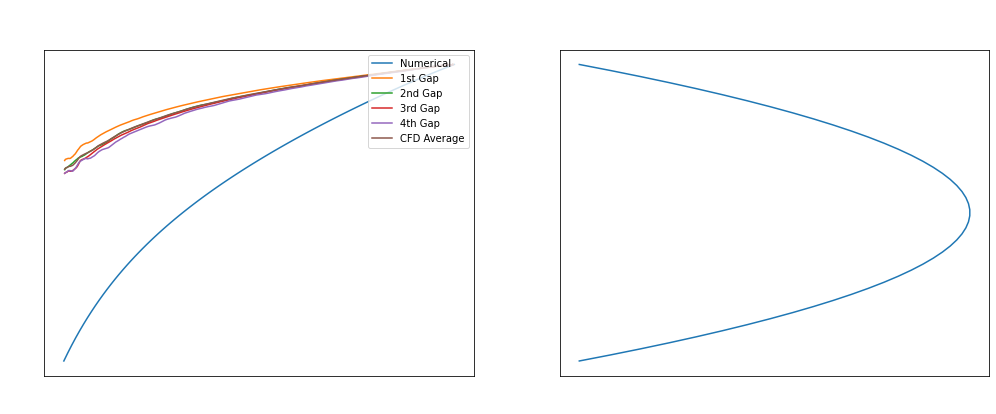

Power:		148.32308914550126 W



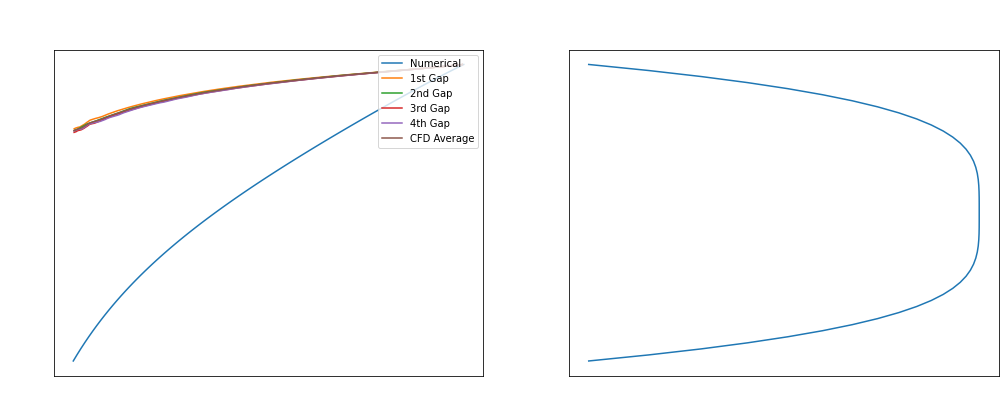

Power:		178.18551931564883 W



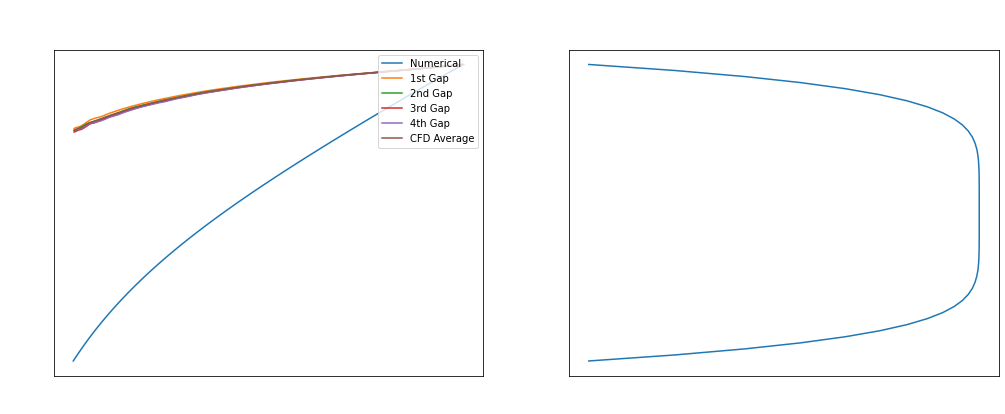

Power:		191.08937615466198 W



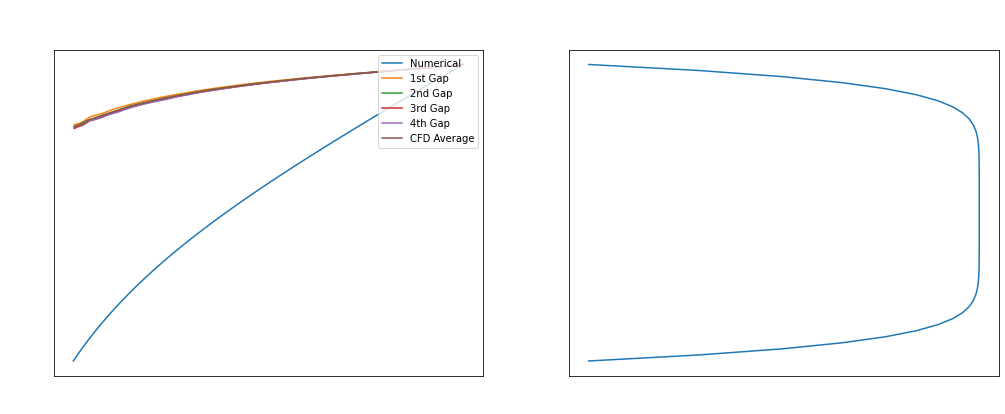

Power:		198.03356867898302 W



In [13]:
df = pd.read_excel("E:\\UoS\\UoS Y4\\GDP Tesla Turbine\\CFD\\fluentData.xlsx")

cfdRadius = np.array(df["Radius"])
cfdRadiusRatio = cfdRadius/rotorOuter

firstTurbGap = np.array(df["1st gap turb"]) - np.amax(np.array(df["1st gap turb"]))
secondTurbGap = np.array(df["2nd gap turb"]) - np.amax(np.array(df["2nd gap turb"]))
thirdTurbGap = np.array(df["3rd gap turb"]) - np.amax(np.array(df["3rd gap turb"]))
fourthTurbGap = np.array(df["4th gap turb"]) - np.amax(np.array(df["4th gap turb"]))
aveTurbGap = np.mean(np.array([firstTurbGap, secondTurbGap, thirdTurbGap, fourthTurbGap]), axis=0)
aveTurbGap = aveTurbGap - np.amax(aveTurbGap)

firstLamGap = np.array(df["1st gap lam"]) - np.amax(np.array(df["1st gap lam"]))
secondLambGap = np.array(df["2nd gap lam"]) - np.amax(np.array(df["2nd gap lam"]))
thirdLamGap = np.array(df["3rd gap lam"]) - np.amax(np.array(df["3rd gap lam"]))
fourthLambGap = np.array(df["4th gap lam"]) - np.amax(np.array(df["4th gap lam"]))
aveLamGap = np.mean(np.array([firstLamGap, secondLambGap, thirdLamGap, fourthLambGap]), axis=0)
aveLamGap = aveLamGap - np.amax(aveLamGap)

profileNFactor = [2,4,6,8]
for i in range(len(profileNFactor)):

    KJ, sol, rs = solutionGenerator(rotorInner, rotorOuter, discSpacing, discThickness, nDisc-1,
                     voluteThickness, wallSpace, 0, wallDisplacement,
                     TotalMassFlowRate, density, revPerMinute[0], profileN = profileNFactor[i])
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    suptitleString = f"profile N = {profileNFactor[i]}"
    plt.subplots_adjust(left = 0.025)
    unnormalisedPressure = sol[:,1]*(density/2)*(KJ.tipVelocity)**2
    ax[0].plot(rs, unnormalisedPressure, label="Numerical")
    
    if i==0:
        fig.suptitle(suptitleString + " (Laminar)", x=0.45, fontsize=20, color="white")
        try:
            ax[0].plot(cfdRadiusRatio, firstLamGap, label="1st Gap")
            ax[0].plot(cfdRadiusRatio, secondLambGap, label="2nd Gap")
            ax[0].plot(cfdRadiusRatio, thirdLamGap, label="3rd Gap")
            ax[0].plot(cfdRadiusRatio, fourthLambGap, label="4th Gap")
            ax[0].plot(cfdRadiusRatio, aveLamGap, label="CFD Average")
        except:
            pass
    else:
        fig.suptitle(suptitleString + " (Turbulent)", x=0.45, fontsize=20, color="white")
        try:
            ax[0].plot(cfdRadiusRatio, firstTurbGap, label="1st Gap")
            ax[0].plot(cfdRadiusRatio, secondTurbGap, label="2nd Gap")
            ax[0].plot(cfdRadiusRatio, thirdTurbGap, label="3rd Gap")
            ax[0].plot(cfdRadiusRatio, fourthTurbGap, label="4th Gap")
            ax[0].plot(cfdRadiusRatio, aveTurbGap, label="CFD Average")
        except:
            pass
    ax[0].yaxis.set_major_formatter(formatter)
    ax[0].set_ylabel('Static pressure drop (Pa)', color='white')
    ax[0].set_xlabel('Radius Ratio', color='white')
    ax[0].legend(loc="upper right")
    
    ax[0].tick_params(axis='x', colors='white')
    ax[0].tick_params(axis='y', colors='white')
    
    profilePlot(ax[1],KJ, 50)
    ax[1].tick_params(axis='x', colors='white')
    ax[1].tick_params(axis='y', colors='white')
    
    plt.show()
    print(
        f"Power:\t\t{power(sol[:,0], rs, KJ)} W"+"\n"
    )